In [3]:
#importing all the assets
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


In [4]:
#loading the data
dataset = pd.read_csv('housing.csv')
print(dataset.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [5]:
#searching for null values
print(dataset.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [6]:
#fixing total bedrooms
dataset['total_bedrooms'] = dataset['total_bedrooms'].fillna(dataset['total_bedrooms'].mean())
print(dataset.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


In [7]:
#enncoding ocean_proximity catagorcial variable to numerical
from sklearn.preprocessing import OneHotEncoder

#inintialising the encoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

#ftting and transforming the data
encoded_data = encoder.fit_transform(dataset[['ocean_proximity']]) 

#creating a new dataframe
#and concatenating it with the original dataset
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['ocean_proximity']))
dataset = pd.concat([dataset, encoded_df], axis=1)

#dropping the original ocean_proximity column
dataset.drop('ocean_proximity', axis=1, inplace=True)
print(dataset.head())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  \
0       322.0       126.0         8.3252            452600.0   
1      2401.0      1138.0         8.3014            358500.0   
2       496.0       177.0         7.2574            352100.0   
3       558.0       219.0         5.6431            341300.0   
4       565.0       259.0         3.8462            342200.0   

   ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     0.0                     0.0   
1   

In [8]:
#splitting the data into features and target variable
X = dataset.drop('median_house_value', axis=1)
y = dataset['median_house_value']

#train and test and validation split
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')


Training set: (14448, 13), (14448,)
Validation set: (3096, 13), (3096,)


In [11]:
#now we will write a locally weighted regression model from scratch
class local_weight_regression:

    #initialising the model
    def __init__(lwr, bandwidth):
        #setting the bandwidth
        lwr.bandwidth = bandwidth 
    #defining the kernel function
    def kernel_func(lwr, distance):
        #gaussian kernel function
        return np.exp(-1 * (distance)**2 / (2 * lwr.bandwidth**2))
    #defining the fit method
    def fit(lwr, X_train, y_train):
        lwr.X_train = X_train.to_numpy()
        lwr.y_train = y_train.to_numpy()
        lwr.global_mean = np.mean(lwr.y_train)
    #defining the predict method
    def predict(lwr, X_test):
        predictions = []
        X_test_np = X_test.to_numpy()

        for i in range(X_test_np.shape[0]):
            #dist calc
            distances = np.linalg.norm(lwr.X_train - X_test_np[i], axis=1)
            
            #weight cal
            weight = lwr.kernel_func(distances)

            #prediction cal
            #explanation of the formula:
            #sum of (weights * y_train) divided by sum of weights
            weight_sum = np.sum(weight)
            if not np.isfinite(weight_sum) or weight_sum <= 1e-12:
                pred = lwr.global_mean
            else:
                pred = np.sum(weight * lwr.y_train) / weight_sum

            predictions.append(pred)

        return np.array(predictions)
    
    

In [18]:
#initialising the model with a bandwidth of 1.0
lwr_model = local_weight_regression(bandwidth=0.2)
#fitting the model
lwr_model.fit(X_train, y_train)

#predicting on the validation set
y_pred = lwr_model.predict(X_val)

#evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 13027693729.38


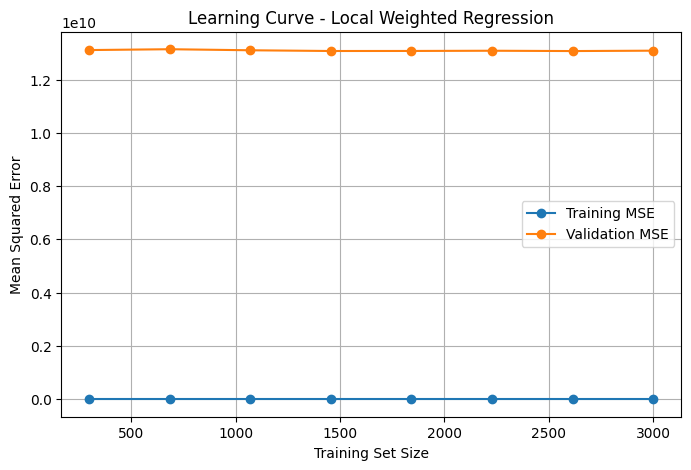

In [16]:
#learning curve for locally weighted regression
from sklearn.metrics import mean_squared_error

#use manageable subset sizes to keep runtime reasonable for this O(n*m) model
max_train_points = min(len(X_train), 3000)
sample_sizes = np.linspace(300, max_train_points, 8, dtype=int)
sample_sizes = np.unique(sample_sizes)

#evaluate on a fixed validation subset for consistent comparison
val_eval_size = min(len(X_val), 800)
X_val_eval = X_val.iloc[:val_eval_size]
y_val_eval = y_val.iloc[:val_eval_size]

train_mse_scores = []
val_mse_scores = []
rng = np.random.RandomState(42)

for size in sample_sizes:
    train_idx = rng.choice(len(X_train), size=size, replace=False)
    X_train_sub = X_train.iloc[train_idx]
    y_train_sub = y_train.iloc[train_idx]

    model = local_weight_regression(bandwidth=1.0)
    model.fit(X_train_sub, y_train_sub)

    y_train_pred = model.predict(X_train_sub)
    y_val_pred = model.predict(X_val_eval)

    train_mse_scores.append(mean_squared_error(y_train_sub, y_train_pred))
    val_mse_scores.append(mean_squared_error(y_val_eval, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, train_mse_scores, marker='o', label='Training MSE')
plt.plot(sample_sizes, val_mse_scores, marker='o', label='Validation MSE')
plt.title('Learning Curve - Local Weighted Regression')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()